In [20]:
from importlib import reload  # Python 3.4+
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from ndbc_api import NdbcApi
import concurrent.futures
from tqdm.contrib.concurrent import process_map, thread_map
from tqdm.autonotebook import tqdm
import xbuoy
import matplotlib
import seaborn as sns

In [61]:
# ------------------------------
# Function 4: Calculate Anomalies (Analysis)
# ------------------------------
def calculate_anomalies(buoy_data):
    """
    Calculate anomalies by subtracting the mean of each buoy's time series.
    
    Parameters:
        buoy_data (xr.DataArray): The buoy data.
    
    Returns:
        xr.DataArray: The anomalies (buoy_data - mean of each buoy).
    """
    mean_buoy_data = buoy_data.mean(dim='time')
    anomalies = buoy_data - mean_buoy_data
    return anomalies

# ------------------------------
# Function 4: Plot Buoy Data (Optional Utility)
# ------------------------------
def plot_buoy_data(buoy_data, buoy_locs, title="Buoy Data Over Time"):
    """
    Plots buoy data over time for each buoy.
    
    Parameters:
        buoy_data (xr.DataArray): Buoy data (n_days, n_buoys).
        buoy_locs (np.ndarray): Array of buoy locations (lat, lon) with shape (n_buoys, 2).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    for b in range(buoy_data.shape[1]):
        plt.plot(buoy_data.time, buoy_data[:, b], marker = "o",
                    label=f"Buoy {b} (Lat: {buoy_locs[b, 0]:.2f}, Lon: {buoy_locs[b, 1]:.2f})")
    plt.title(title)
    plt.xlabel("Time (Days)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()

In [153]:
extrema = lambda x: np.array((x.min().values, x.max().values))
buoy_ds = xr.open_dataset("../data/NDBC_CC_Daily.nc")


In [509]:
extrema = lambda x: np.array((x.min().values, x.max().values))
buoy_ds = xr.open_dataset("../data/NDBC_CC_Daily.nc")[["WTMP", "latitude", "longitude", "wtemp_coverage"]]
buoy_ds = buoy_ds.resample(time="3M").mean("time")
buoy_ds = buoy_ds.where(buoy_ds["wtemp_coverage"] > 80, drop = True)
# buoy_ds = buoy_ds.where((buoy_ds.latitude > 33) * (buoy_ds.latitude < 34.5) * (buoy_ds.longitude > -122.5) * (buoy_ds.longitude < -110), drop = True)
buoy_ds = buoy_ds.where((buoy_ds.latitude > 33) * (buoy_ds.latitude < 60) * (buoy_ds.longitude > -122.5) * (buoy_ds.longitude < -110), drop = True)

buoy_locs = np.column_stack((buoy_ds.latitude[0, :].values, buoy_ds.longitude[0, :].values))

# buoy_ds = buoy_ds.isel(time = slice(1000, 1050))

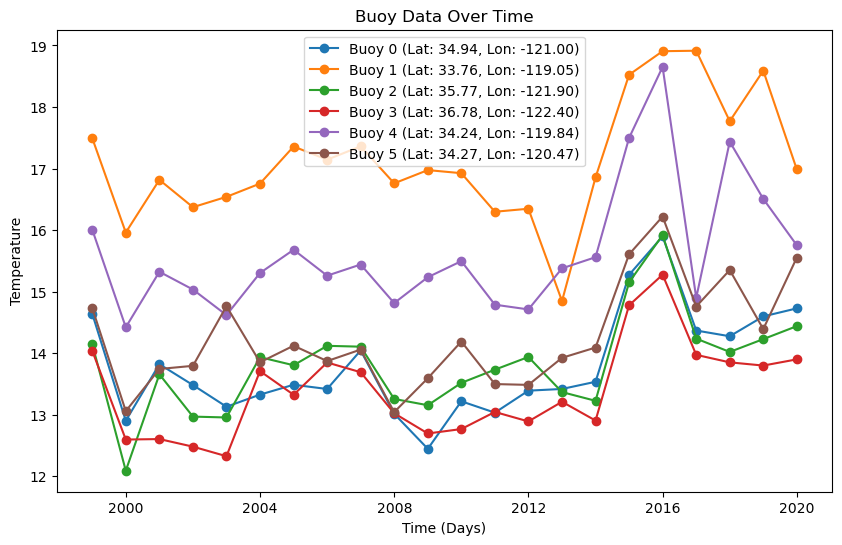

In [510]:
plot_buoy_data(buoy_ds["WTMP"], buoy_locs, title="Buoy Data Over Time")

In [511]:
buoy_anomalies = calculate_anomalies(buoy_ds["WTMP"])
n_days = len(buoy_anomalies.time)
time_feature = np.arange(1, n_days + 1)  # Time


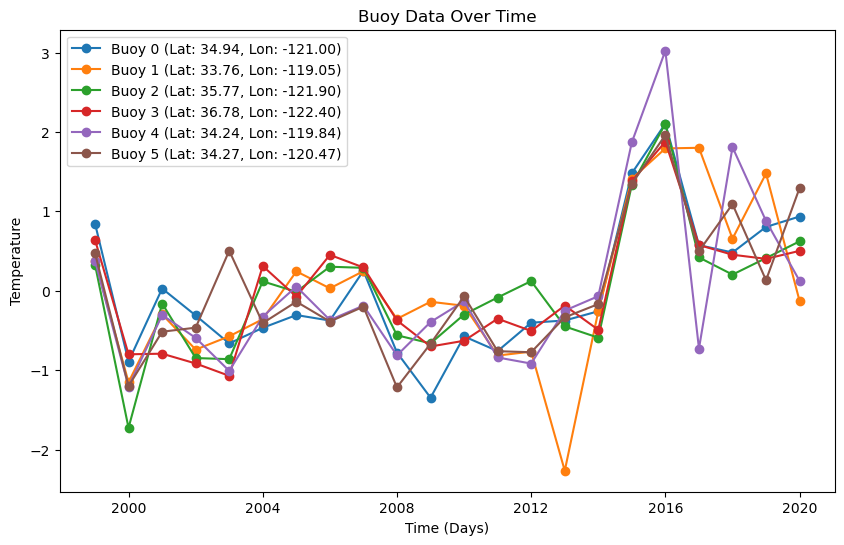

In [512]:
plot_buoy_data(buoy_anomalies, buoy_locs, title="Buoy Data Over Time")

In [513]:
# Prepare training data using anomalies from all buoys (excluding missing data from target buoy)
X_train_full = []
y_train_full = []

# Loop over all buoys to gather training data for GPR
for b in range(len(buoy_locs)):
    lat_np = np.full((n_days, 1), buoy_locs[b, 0])  # Latitude for each time point
    lon_np = np.full((n_days, 1), buoy_locs[b, 1])  # Longitude for each time point
    time_np = time_feature.reshape(-1, 1)  # Time as a feature
    
    X_train_buoy = np.hstack([lat_np, lon_np, time_np])
    # X_train_buoy = np.hstack([lat_np, lon_np])
    y_train_buoy = buoy_anomalies[:, b].values
    
    observed_indices = ~np.isnan(buoy_anomalies[:, b])
    X_train_full.append(X_train_buoy[observed_indices])
    y_train_full.append(y_train_buoy[observed_indices])

# Convert lists to numpy arrays
X_train_full = np.vstack(X_train_full)  # Stack all buoy data vertically
y_train_full = np.concatenate(y_train_full)  # Concatenate target values

In [514]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, Matern, ConstantKernel as C

# Initialize the Gaussian Process Regressor with the kernel
# kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 10))
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.1, 0.1, 1.0],  # Smaller initial length scales
                                      length_scale_bounds=[(1e-2, 10), (1e-2, 10), (0.1, 10)], 
                                      nu=0.5) + \
         WhiteKernel(noise_level=0.3, noise_level_bounds=(1e-5, 0.5))

gp_full = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)

In [515]:
# Train the GPR model using the anomalies dataset
gp_full.fit(X_train_full, y_train_full)

/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[0.1, 0.1, 1], nu=0.5) + WhiteKernel(noise_level=0.3),
                         n_restarts_optimizer=10)

In [516]:
gp_full

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[0.1, 0.1, 1], nu=0.5) + WhiteKernel(noise_level=0.3),
                         n_restarts_optimizer=10)

In [517]:
print("Initial kernel parameters:")
print(gp_full.kernel.get_params())

print("\nOptimized kernel parameters:")
print(gp_full.kernel_)

Initial kernel parameters:
{'k1': 1**2 * Matern(length_scale=[0.1, 0.1, 1], nu=0.5), 'k2': WhiteKernel(noise_level=0.3), 'k1__k1': 1**2, 'k1__k2': Matern(length_scale=[0.1, 0.1, 1], nu=0.5), 'k1__k1__constant_value': 1.0, 'k1__k1__constant_value_bounds': (0.001, 1000.0), 'k1__k2__length_scale': [0.1, 0.1, 1.0], 'k1__k2__length_scale_bounds': [(0.01, 10), (0.01, 10), (0.1, 10)], 'k1__k2__nu': 0.5, 'k2__noise_level': 0.3, 'k2__noise_level_bounds': (1e-05, 0.5)}

Optimized kernel parameters:
0.7**2 * Matern(length_scale=[10, 8.15, 1.24], nu=0.5) + WhiteKernel(noise_level=0.105)


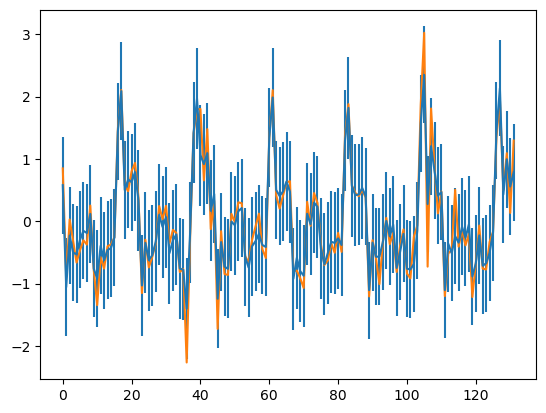

In [518]:
test, test_std = gp_full.predict(X_train_full, return_std=True)
plt.errorbar(np.arange(len(test)), test, yerr = 2 * test_std)
plt.plot(y_train_full)

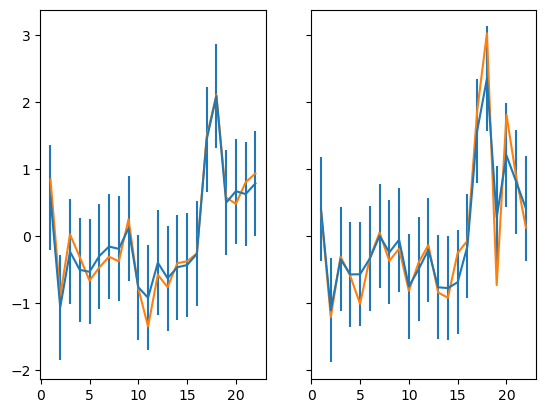

In [521]:
fig, axes = plt.subplots(1, 2, sharey = True)

b = 0
lat_np = np.full((n_days, 1), buoy_locs[b, 0])  # Latitude for each time point
lon_np = np.full((n_days, 1), buoy_locs[b, 1])  # Longitude for each time point
time_np = time_feature.reshape(-1, 1)  # Time as a feature

X_train_buoy = np.hstack([lat_np, lon_np, time_np])
y_pred_full, y_std_full = gp_full.predict(X_train_buoy, return_std=True)

axes[0].errorbar(time_np, y_pred_full, yerr = 2 * y_std_full)
axes[0].plot(time_np,  buoy_anomalies[:, b].values)

b = 4
lat_np = np.full((n_days, 1), buoy_locs[b, 0])  # Latitude for each time point
lon_np = np.full((n_days, 1), buoy_locs[b, 1])  # Longitude for each time point
time_np = time_feature.reshape(-1, 1)  # Time as a feature

X_train_buoy = np.hstack([lat_np, lon_np, time_np])
y_pred_full, y_std_full = gp_full.predict(X_train_buoy, return_std=True)

axes[1].errorbar(time_np, y_pred_full, yerr = 2 * y_std_full)
axes[1].plot(time_np,  buoy_anomalies[:, b].values)


In [522]:
lat_range = (buoy_locs[:, 0].min(), buoy_locs[:, 0].max())  # Latitude range
lon_range = (buoy_locs[:, 1].min(), buoy_locs[:, 1].max())  # Longitude range

In [523]:
grid_size = 25
pulse_midpoint = 20
print(buoy_ds.isel(time = pulse_midpoint).time)

# Create a meshgrid for lat/lon
lat_min, lat_max = min(lat_range), max(lat_range)
lon_min, lon_max = min(lon_range), max(lon_range)
grid_lat, grid_lon = np.meshgrid(np.linspace(lat_min, lat_max, grid_size), np.linspace(lon_min, lon_max, grid_size))

# Flatten the grid coordinates to create the feature matrix for GPR prediction
grid_points = np.vstack([grid_lat.ravel(), grid_lon.ravel()]).T  # Shape: (grid_size^2, 2)
time_at_pulse = np.full((grid_points.shape[0], 1), pulse_midpoint)  # Shape: (grid_size^2, 1)

# Combine the time and spatial features for the grid
X_grid = np.hstack([grid_points, time_at_pulse])

# Predict the temperature anomaly at each grid point using GPR
y_grid_pred, y_grid_std = gp_full.predict(X_grid, return_std=True)

# Reshape the predictions back to the grid shape for plotting
y_grid_pred_reshaped = y_grid_pred.reshape(grid_size, grid_size)

<xarray.DataArray 'time' ()> Size: 8B
array('2018-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2018-12-31


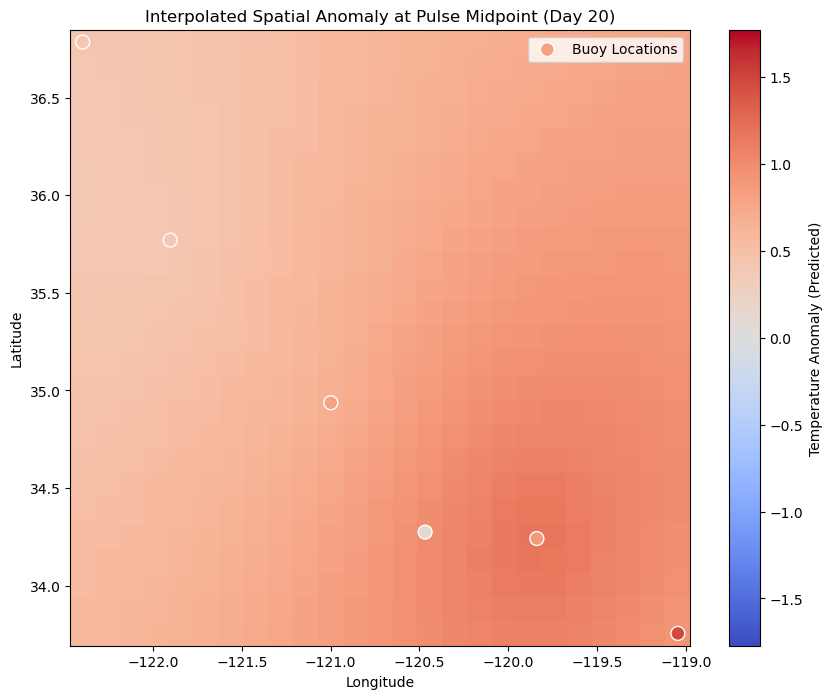

In [524]:

# Plot the spatial anomaly field (with contours and scatter plot)
plt.figure(figsize=(10, 8))

# Find symmetric color limits
vmax = max(np.nanmax(np.abs(buoy_anomalies.isel(time = pulse_midpoint))), np.nanmax(np.abs(y_grid_pred_reshaped)))
vmax = vmax * 1.2
vmin = -vmax

# Create a contour plot for the interpolated temperature anomaly field
contour = plt.pcolormesh(grid_lon.T, grid_lat.T, y_grid_pred_reshaped.T, cmap='coolwarm', vmin=vmin, vmax=vmax)

# Add color bar to show the temperature anomaly scale
plt.colorbar(contour, label='Temperature Anomaly (Predicted)')

# Scatter plot of the buoy locations with their anomalies
plt.scatter(buoy_locs[:, 1], buoy_locs[:, 0], c=buoy_anomalies.isel(time=pulse_midpoint), 
            s=100, edgecolor='white', label='Buoy Locations', 
            cmap = "coolwarm", vmin=vmin, vmax=vmax)

# Set plot labels and title
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Interpolated Spatial Anomaly at Pulse Midpoint (Day {pulse_midpoint})')

plt.legend()
plt.show()
